In [1]:
# Load necessary libraries
import os, random
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller    # For ADF test
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras                      # TensorFlow does not support Python 3.12 yet (as of June 2025)
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
## Algorithm 1 & 2: Data Preparation and Quarterly Aggregation of Variables

# 1. Load the master dataset
df = pd.read_csv('scenario_A_stationary.csv')

# 2. Parse the DATE column and create a quarter identifier
df['DATE'] = pd.to_datetime(df['DATE'])
df['quarter'] = df['DATE'].dt.to_period('Q')

# 3. Specify the target variable name
Y_col = 'Y_q' 

# 5. Identify explanatory variables (exclude DATE, quarter, and Y column)
exclude_cols = {'DATE', 'quarter', Y_col}
x_cols = [col for col in df.columns if col not in exclude_cols]

# 6. Run ADF test for each explanatory variable
adf_results = pd.DataFrame(columns=["Variable", "ADF Statistic", "p-value", "Stationary at 5%"])
X_prime_m_df = df[['DATE', 'quarter']].copy()  # To store transformed monthly variables

for col in x_cols:
    series_original = df[col].copy()
    series_numeric = pd.to_numeric(series_original, errors='coerce').dropna()

    if not series_numeric.empty:
        result = adfuller(series_numeric)
        adf_stat = result[0]
        p_value = result[1]
        is_stationary = p_value < 0.05
        adf_results.loc[len(adf_results)] = [col, adf_stat, p_value, is_stationary]
    else:
        adf_results.loc[len(adf_results)] = [col, np.nan, np.nan, False]

# Display ADF test results
adf_results_display = adf_results.set_index("Variable").sort_values("p-value")
print("\n=== ADF Test Results ===")
print(adf_results_display)



=== ADF Test Results ===
          ADF Statistic       p-value  Stationary at 5%
Variable                                               
X_0          -20.128883  0.000000e+00              True
X_1          -18.857250  0.000000e+00              True
X_3          -19.676494  0.000000e+00              True
X_2          -18.608189  2.066285e-30              True
X_4          -18.232482  2.365437e-30              True


In [3]:
# 7. Manually specify which X columns should be log-differenced
log_diff_cols = []

# 8. Identify explanatory variables that are not log-differenced
non_log_cols = [col for col in x_cols if col not in log_diff_cols]

# 9. Apply transformation to create X_prime_m_df (transformed monthly X)
for col in x_cols:
    if col in log_diff_cols:
        if (df[col] <= 0).any():
            print(f"Warning: Column {col} contains non-positive values. Applying log.diff() may result in NaNs or errors.")
            try:
                X_prime_m_df[col] = np.log(df[col].replace(0, np.nan)).diff()
            except Exception as e:
                print(f"Error log-differencing {col}: {e}. Column will be NaN.")
                X_prime_m_df[col] = np.nan
        else:
            X_prime_m_df[col] = np.log(df[col]).diff()
    else:
        X_prime_m_df[col] = df[col].copy()


# 10. Group the transformed monthly X by quarter
quarter_groups_X_prime = X_prime_m_df.groupby('quarter')

# 11. For log-differenced variables, take the quarterly sum
x_q_aggregated_log = quarter_groups_X_prime[log_diff_cols].sum() if log_diff_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 12. For non-log-differenced variables, take the quarterly mean
x_q_aggregated_nonlog = quarter_groups_X_prime[non_log_cols].mean() if non_log_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 13. Combine aggregated quarterly explanatory variables
X_q_aggregated = pd.concat([x_q_aggregated_log, x_q_aggregated_nonlog], axis=1).sort_index()

# 14. Extract quarterly target observations (use the first month of each quarter)
y_q_levels_df = (
    df[df[Y_col].notna()][['quarter', Y_col]]
    .drop_duplicates(subset='quarter', keep='first')    # Ensure we take the first month of each quarter
    .set_index('quarter')
    .sort_index()
)

# 15. Align aggregated X with quarterly Y
common_index = X_q_aggregated.index.intersection(y_q_levels_df.index)
X_q_aligned = X_q_aggregated.loc[common_index]
Y_q_levels = y_q_levels_df.loc[common_index, Y_col]

# 16. Convert Y to quarterly log difference (growth rate)
Y_q_processed = np.log(Y_q_levels).diff().dropna()

# 17. Align X again with the log-differenced Y (drops one more quarter)
X_q_processed = X_q_aligned.loc[Y_q_processed.index]

# Display
print("\n--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---")
print("Processed Quarterly X shape:", X_q_processed.shape)
print("Processed Quarterly Y shape:", Y_q_processed.shape)
print("\nX_q_processed (first few rows):")
print(X_q_processed.head())
print("\nY_q_processed (first few rows):")
print(Y_q_processed.head())


--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---
Processed Quarterly X shape: (119, 5)
Processed Quarterly Y shape: (119,)

X_q_processed (first few rows):
              X_0       X_1       X_2       X_3       X_4
quarter                                                  
1990Q2   0.351580  0.230212  0.243382  0.962908 -0.516167
1990Q3   0.625724  0.111454 -0.057915  0.336677  0.432010
1990Q4  -0.128862 -0.083500 -0.520277 -0.101724  0.677440
1991Q1  -1.132079  1.521199 -0.088392  0.504072  1.135982
1991Q2  -0.420290  0.096105  0.570439 -0.666761 -0.208754

Y_q_processed (first few rows):
quarter
1990Q2   -0.032716
1990Q3    0.016798
1990Q4    0.000844
1991Q1    0.014885
1991Q2   -0.036908
Freq: Q-DEC, Name: Y_q, dtype: float64


In [4]:
## Algorithm 3: Neural Network Hyperparameter Optimization

# Set Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 1. Split the data into training and test sets (80/20 split)
split_idx = int(len(X_q_processed) * 0.8)
X_q_train = X_q_processed.iloc[:split_idx]
Y_q_train = Y_q_processed.iloc[:split_idx]
X_q_test = X_q_processed.iloc[split_idx:]
Y_q_test = Y_q_processed.iloc[split_idx:]

# 2. Standardize non-log-differenced columns
scaler = StandardScaler()    # Z-score
X_q_train_scaled = X_q_train.copy()
X_q_test_scaled = X_q_test.copy()
if non_log_cols:
    X_q_train_scaled[non_log_cols] = scaler.fit_transform(X_q_train[non_log_cols])  # For training data, fit the scaler
    X_q_test_scaled[non_log_cols] = scaler.transform(X_q_test[non_log_cols])        # For test data, we do not fit again, just transform to avid data leakage

# Sign accuracy funtion
def sign_acc_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32))

# 3. KerasTuner funtion
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_q_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 6)):  # up to 6 layers (may increase for more complexity)
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=8, max_value=700, step=10),
                activation=hp.Choice('activation', ['relu', 'tanh', 'elu', 'selu', 'swish'])
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)
            )
        )
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(         # Adam optimizer
            learning_rate=hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
        ),
        loss='mse',
        metrics=['mse', sign_acc_metric]
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mse',
    max_trials=100,                              # Increase trials for better search
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='gdp_q_nn_wide'
)

tuner.search(
    X_q_train_scaled.values, Y_q_train.values,
    epochs=200,
    batch_size=4,
    validation_data=(X_q_test_scaled.values, Y_q_test.values),
    callbacks=[keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)],
    verbose=2
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n[Best Hyperparameters]")
for k,v in best_hp.values.items():
    print(f"{k}: {v}")

Trial 100 Complete [00h 00m 15s]
val_mse: 0.00020382640650495887

Best val_mse So Far: 0.00011662257747957483
Total elapsed time: 00h 38m 02s

[Best Hyperparameters]
num_layers: 4
units_0: 168
activation: elu
dropout_0: 0.2
lr: 0.005
units_1: 588
dropout_1: 0.05
units_2: 438
dropout_2: 0.25
units_3: 298
dropout_3: 0.25
units_4: 298
dropout_4: 0.05
units_5: 188
dropout_5: 0.30000000000000004


/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


2025-06-24 09:58:58.801565: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 09:58:58.802548: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


[Model Evaluation on Test Set]
Test MSE: 0.000117
Test RMSE: 0.010799
Test MAE: 0.009005
Test R²: 0.181
Sign Accuracy: 62.50%
sMAPE: 124.56%
Theil's U1: 0.539

'test_MLP_UK.csv' saved.
'test_MLP_A_summary_metrics.csv' saved.


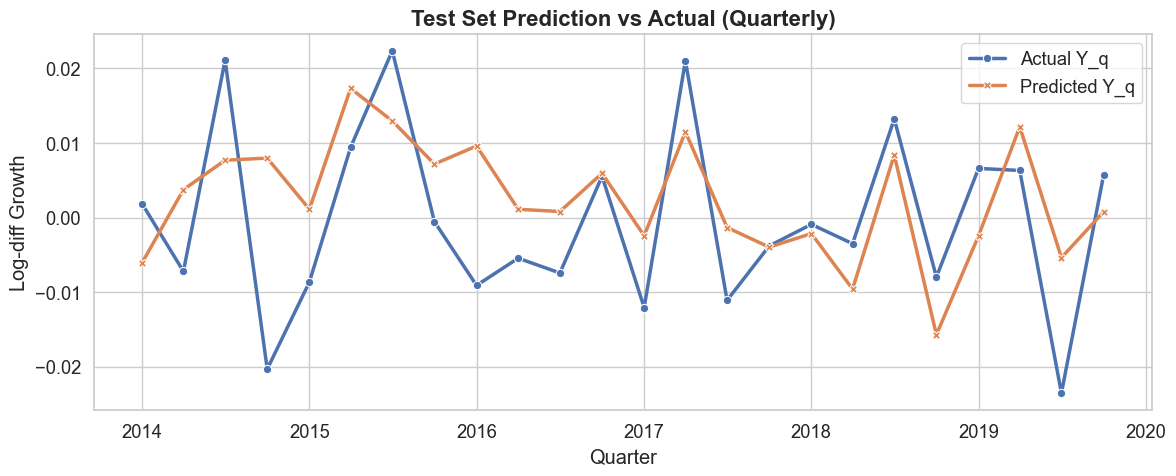

In [ ]:
# 5. Quarterly Prediction and Evaluation
y_test_pred = best_model.predict(X_q_test_scaled.values).flatten()

# Define functions for sMAPE and Theil's U1
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)
    return np.mean(ratio) * 100

def theil_u1(y_true, y_pred):
    """Theil's U1 statistic for forecast accuracy"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rms_actual = np.sqrt(np.mean(y_true**2))
    rms_pred = np.sqrt(np.mean(y_pred**2))
    if (rms_actual + rms_pred) == 0:
        return np.nan
    return rmse / (rms_actual + rms_pred)

# Calculate all metrics
mse = mean_squared_error(Y_q_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_q_test, y_test_pred)
r2 = r2_score(Y_q_test, y_test_pred)
sign_acc = (np.sign(y_test_pred) == np.sign(Y_q_test)).mean()
smape_val = smape(Y_q_test, y_test_pred)
theil_u1_val = theil_u1(Y_q_test, y_test_pred)

# Print all metrics
print("\n[Model Evaluation on Test Set]")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²: {r2:.3f}")
print(f"Sign Accuracy: {sign_acc:.2%}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"Theil's U1: {theil_u1_val:.3f}")


# Create a DataFrame for per-prediction results
results_index = Y_q_test.index
results_df = pd.DataFrame({
    "Quarter": results_index.to_timestamp(),
    "Actual_Y_q": Y_q_test,
    "Predicted_Y_q": y_test_pred,
    "Sign_Match": (np.sign(y_test_pred) == np.sign(Y_q_test)).astype(int)
})
results_df.to_csv("test_MLP_A_stationary.csv", index=False)
print("\n'test_MLP_A_stationary.csv' saved.")

# Create and save a DataFrame for the summary metrics
metrics_summary_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Sign Accuracy', 'sMAPE', 'Theil U1'],
    'Value': [mse, rmse, mae, r2, sign_acc, smape_val, theil_u1_val]
})
metrics_summary_df.to_csv("test_MLP_A_summary_metrics_stationary.csv", index=False)
print("'test_MLP_A_summary_metrics_stationary.csv' saved.")

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 5))
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=Y_q_test.values, label="Actual Y_q", marker="o")
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test_pred, label="Predicted Y_q", marker="X")

plt.title("Test Set Prediction vs Actual (Quarterly)", fontsize=16, weight='bold')
plt.xlabel("Quarter")
plt.ylabel("Log-diff Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 6. Monthly GDP prediction with reconciliation (Proportional Denton)

# Monthly X scaling (matching columns and order used in model training)
X_m_scaled = X_prime_m_df[X_q_train.columns].copy()
if non_log_cols:
    X_m_scaled[non_log_cols] = scaler.transform(X_m_scaled[non_log_cols])

# Monthly "quarterly-perspective" growth prediction
monthly_y_pred_nn = best_model.predict(X_m_scaled.values).flatten()
monthly_predictions_df = pd.DataFrame({
    'raw_quarterly_log_diff_pred': monthly_y_pred_nn
}, index=X_prime_m_df['DATE'])
monthly_predictions_df.index = pd.to_datetime(monthly_predictions_df.index)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# Naive monthly growth: simply distribute predicted quarterly growth equally to each month
monthly_predictions_df['naive_monthly_log_diff'] = monthly_predictions_df['raw_quarterly_log_diff_pred'] / 3.0

# Actual observed quarterly log growth (Y_q_processed)
actual_quarterly_log_diffs = Y_q_processed.copy()
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# For each quarter, calculate scaling factor so the sum of naive monthly growths matches actual quarterly growth
quarterly_sum_of_naive = monthly_predictions_df.groupby('quarter')['naive_monthly_log_diff'].sum()
adjusted_monthly_log_diffs = pd.Series(index=monthly_predictions_df.index, dtype=float)

for quarter, group in monthly_predictions_df.groupby('quarter'):
    if quarter in actual_quarterly_log_diffs.index and quarter in quarterly_sum_of_naive.index:
        actual_q_log_diff = actual_quarterly_log_diffs.loc[quarter]
        sum_naive = quarterly_sum_of_naive.loc[quarter]
        if sum_naive != 0:
            adjustment_factor = actual_q_log_diff / sum_naive
            adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff'] * adjustment_factor
        else:
            # If sum_naive is zero, evenly distribute actual growth across the months in the quarter
            adjusted_monthly_log_diffs.loc[group.index] = actual_q_log_diff / len(group)
    else:
        # If we have no actual value, just use the naive value
        adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff']

monthly_predictions_df['adjusted_monthly_log_diff'] = adjusted_monthly_log_diffs

# Export predicted monthly GDP growth as CSV
mgdp_pred_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff']
}, index=monthly_predictions_df.index)
mgdp_pred_df.index.name = "DATE"
mgdp_pred_df.to_csv("A_monthly_GDP_MLP_growth_stationary.csv")
print("A_monthly_GDP_MLP_growth_stationary.csv saved")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
A_monthly_GDP_MLP_growth.csv saved


2025-06-24 09:59:38.658605: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 09:59:38.659817: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),